# Product prices analysis

In [1]:
from libs.priceAnalysisMethods import *


In [2]:
sc, sql_ctx, spark = init_spark("App_name", "local[4]")

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
df = spark.read.option("header", "true").csv("../data/cat_csv/*.csv")
df = cleanPriceSparkDF(df)

## DF Imported and cleaned at this point

In [5]:
df.show(10)

+---+--------------------+----------+--------+------+-------------+----------+--------------------+----------+
|_c0|                name|     price|    from|    to|       vendor|  cat_hash|                 cat|      date|
+---+--------------------+----------+--------+------+-------------+----------+--------------------+----------+
|  0|Jack Herer from S...|0.73044494|   [usa]|[None]|   MrSunshine|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  1|WHITE WIDOW FEMIN...|3.31830703|[europe]|[None]|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  2|WHITE WIDOW FEMIN...|0.85149010|[europe]|[None]|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  3|SMART START - See...|0.07091576|[europe]|[None]|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  4|Marijuana Grow Ba...|0.00542616|  [None]|[None]|      Optumis|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  5|SMART START - See...|0.07091576|[europe]|[None]|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|

In [6]:
# Call method to preprocess data
dfAvgBTCprice = sparkProdPricesPrep(df)
# Export Agregated data to pandas
pdAvgPriceDF = dfAvgBTCprice.toPandas()

### Load BTC prices

In [7]:
# Load dataframe
btcPriceDF= pd.read_csv("../data/bitcoin_csv.csv",usecols=['date', 'price(USD)'])


In [8]:
# preporcess df
btcPriceDF = preprocessBTCprices(btcPriceDF)
btcPriceDF.head(5)

,price
date,
2013-04-28,135.30
2013-04-29,134.44
2013-04-30,144.00
2013-05-01,139.00
2013-05-02,116.38


In [9]:
pdAvgPriceDF = convertBTCprices(pdAvgPriceDF,btcPriceDF)
pdAvgPriceDF.head(5)

,date,avgPrice(BTC),nbOfProducts,avgPrice(dollars)
0,2015-05-01,1.118939,60,264.002491
1,2015-02-09,2.386418,19849,533.101857
2,2015-02-26,2.399288,20831,569.446955
3,2015-02-28,2.329680,20887,590.620497
4,2014-11-01,2.410736,18663,816.395652


# Plot Prices over time 

In [10]:
pdAvgPriceDF = pdAvgPriceDF.set_index('date')


In [11]:
# clean outliers en mode cochon
pdAvgPriceDF = pdAvgPriceDF[pdAvgPriceDF['avgPrice(dollars)'] < 25000]

In [12]:
pdAvgPriceDF = pdAvgPriceDF.sort_index()

In [13]:
pdAvgPriceDF.index

DatetimeIndex(['2014-01-01', '2014-01-09', '2014-01-16', '2014-01-26',
               '2014-02-02', '2014-02-05', '2014-02-10', '2014-02-15',
               '2014-02-18', '2014-02-23',
               ...
               '2015-06-13', '2015-06-15', '2015-06-20', '2015-06-22',
               '2015-06-26', '2015-06-28', '2015-06-30', '2015-07-01',
               '2015-07-04', '2015-07-07'],
              dtype='datetime64[ns]', name='date', length=201, freq=None)

In [14]:
#plotPriceOneLine(pdAvgPriceDF.index,pdAvgPriceDF['avgPrice(dollars)'], 15 ,'Average products price along time','avgProductsPrice($)')

## Trying to clean data 

In [15]:
dateSerie = pdAvgPriceDF.index.to_series()
dateSerie = dateSerie.reset_index(drop=True)

In [16]:
compressionWidth = 20

In [17]:
correctedDF= pdAvgPriceDF.copy()

In [18]:
correctedDF.iloc[compressionWidth:-compressionWidth] = correctedDF.iloc[compressionWidth:-compressionWidth].apply(lambda x: correctOutliers(x,compressionWidth,dateSerie,pdAvgPriceDF), axis=1)

In [19]:
rolledDF = correctedDF.copy()
rolledDF = rolledDF.rolling(10).mean()

## Plot cleaned data

In [20]:
plottedDataFrame = rolledDF

/home/quentin/programs/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



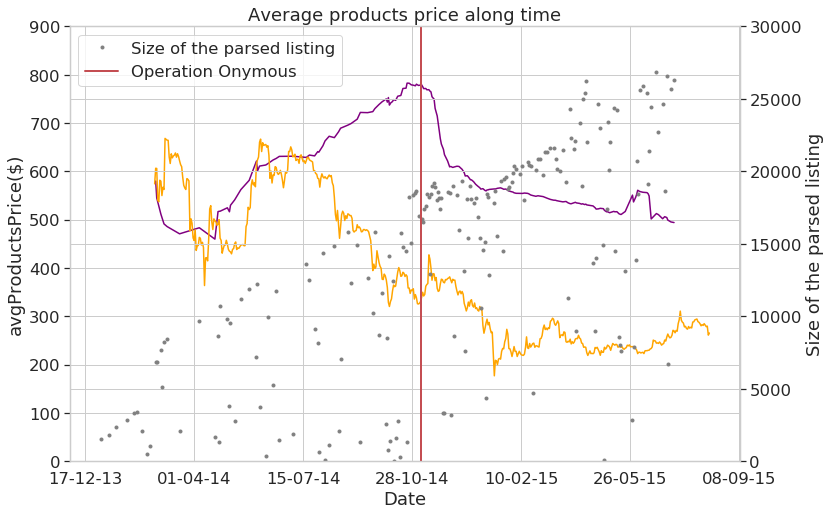

In [21]:
PlotPrice2LinesAndDots(plottedDataFrame.index,plottedDataFrame['avgPrice(dollars)'],pdAvgPriceDF['nbOfProducts'], 15 ,'Average products price along time','avgProductsPrice($)','Size of the parsed listing',btcPriceDF)